In [2]:
from components import *
from modular_network import Network
import mnist_loader, fashion_mnist_loader
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sci

In [3]:
mnist_train, mnist_val, mnist_test = mnist_loader.load_data_wrapper("../data/mnist.pkl.gz")

In [4]:
# Modify the data for an autoencoder process
for i, tuple_i in enumerate(mnist_train):
    mnist_train[i] = (tuple_i[0], np.reshape(tuple_i[0], (28*28, 1)))

In [6]:
autoencoder = Network([
    Flatten((28, 28)),
    FullyConnected(28*28, 30, tanh(), None),
    FullyConnected(30, 30, tanh(), None),
    FullyConnected(30, 28*28, tanh(), None),
])

In [7]:
autoencoder.set_cost(QuadraticCost())
autoencoder.set_optimizer(Adam_optimizer(0.005, 20, 0.99, 0.999))
training_stats = autoencoder.train(mnist_train, 30, 20, monitor_training_cost=True)

Epoch 1 training complete, took 12.439358711242676 seconds
Cost on training data: 22.19841775244351
Epoch 2 training complete, took 11.473106861114502 seconds
Cost on training data: 16.857808908758532
Epoch 3 training complete, took 11.544959783554077 seconds
Cost on training data: 14.51809692960374
Epoch 4 training complete, took 11.732041120529175 seconds
Cost on training data: 12.655158024884292
Epoch 5 training complete, took 12.445944786071777 seconds
Cost on training data: 11.65219566000387
Epoch 6 training complete, took 11.822278022766113 seconds
Cost on training data: 10.89564616136813
Epoch 7 training complete, took 11.587813377380371 seconds
Cost on training data: 10.406696062410253
Epoch 8 training complete, took 11.656596660614014 seconds
Cost on training data: 9.925333879769758
Epoch 9 training complete, took 11.485033512115479 seconds
Cost on training data: 9.610984009398697
Epoch 10 training complete, took 11.658834457397461 seconds
Cost on training data: 9.319585609768

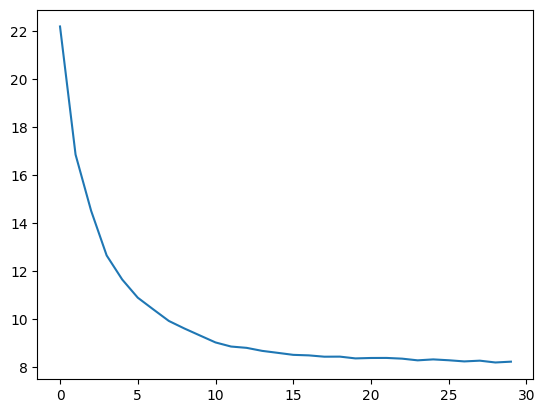

In [9]:
plt.plot(training_stats["training_cost"])

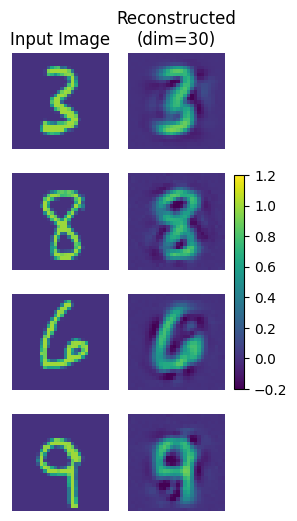

In [16]:
total = 4
square_size = 1.5
fig, axes = plt.subplots(total, 2, figsize=(square_size*2, square_size*total))  # 1 row, 2 columns

vmin = -0.2
vmax = 1.2

for test_image_index in range(total):

    test_image = mnist_val[test_image_index][0]
    ae_output = autoencoder.feedforward(np.array([test_image]))
    ae_output = np.reshape(ae_output, (28, 28))

    im1 = axes[test_image_index][0].imshow(test_image, vmin = vmin, vmax = vmax)    
    im2 = axes[test_image_index][1].imshow(ae_output, vmin = vmin, vmax = vmax)

    if test_image_index == 0:
        axes[test_image_index][0].set_title("Input Image")
        axes[test_image_index][1].set_title("Reconstructed\n(dim=30)")

cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.046, pad=0.04)

for axarr_1d in axes:
    for ax in axarr_1d:
        ax.axis("off")

plt.show()
